In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'2.2.2+cu121'

### Create Dataset

In [2]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

### Data visualizzation

In [4]:
print("First 10 samples: ", X[:10])
print("First 10 labels: ", y[:10])

First 10 samples:  [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First 10 labels:  [1 1 1 1 0 1 1 1 1 0]


In [5]:
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "label": y})


In [6]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


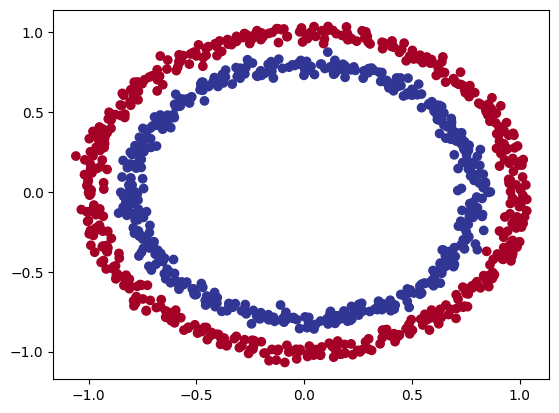

In [7]:
plt.scatter(x=X[:,0], 
            y=X[:,1],
            c = y,
            cmap=plt.cm.RdYlBu)

In [8]:
print(f"X Shape: {X.shape} | Y Shape: {y.shape}")
print(f"X example: {X[0]} | Y example: {y[0]}")

X Shape: (1000, 2) | Y Shape: (1000,)
X example: [0.75424625 0.23148074] | Y example: 1


### Convert to tensor

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
print(X.dtype, y.dtype)
X[:5], y[:5]

torch.float32 torch.float32


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

### Spliting Dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])


### Buiding a Linear model for not linear Dataset

In [13]:
class ClassifierModelV1(nn.Module):
    def __init__(self):
        super(ClassifierModelV1, self).__init__()
        self.layer_1 = nn.Linear(in_features= 2, out_features=5)
        self.layer_2 = nn.Linear(in_features= 5, out_features=1)
        
    # Or we can: 
    #self.two_linear = nn.Sequential(
    #       nn.Linear(in_features=2, out_features=5), 
    #       nn.Linear(in_features=5, out_features=1))
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        
model0 = ClassifierModelV1().to(device)

In [14]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [15]:
model0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4917,  0.2554],
                      [ 0.3546,  0.4147],
                      [ 0.0401, -0.5676],
                      [-0.4342, -0.3334],
                      [ 0.1638,  0.6494]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.6677,  0.4269, -0.6002, -0.2563,  0.3893], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0890, -0.0486,  0.0952,  0.2827,  0.0556]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.4074], device='cuda:0'))])

In [16]:
print(X_test.shape)

torch.Size([200, 2])


In [17]:
with torch.inference_mode():
    untrined_preds = model0.forward(X_test.to(device))

In [18]:
print(untrined_preds.shape)

torch.Size([200, 1])


In [19]:
print(f"First 10 predictions {torch.round(untrined_preds[:10])} | First 10 labels {y_train[:10]}")

First 10 predictions tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-0.],
        [-1.]], device='cuda:0') | First 10 labels tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


### Use it a BCEWithLogitsLoss() 
#### is a powerful and numerically stable loss function for binary and multilabel classification, combining the sigmoid activation function and Binary Cross Entropy loss

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.001)

### Calculate accuracy 

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

### Transform the Logits in Probabilities 

In [22]:
predict_prob = torch.sigmoid(untrined_preds[:10])
predict_prob

tensor([[0.3385],
        [0.3218],
        [0.3803],
        [0.3270],
        [0.3743],
        [0.3636],
        [0.3204],
        [0.3299],
        [0.3805],
        [0.3206]], device='cuda:0')

In [23]:
print(torch.round(predict_prob))

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


In [24]:
print(torch.round(untrined_preds[:10]))

tensor([[-1.],
        [-1.],
        [-0.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-0.],
        [-1.]], device='cuda:0')


In [25]:
print(y_test[:10])

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Building a training and testing loop

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model0.to(device)

for epoch in range(epochs):
    # Training
    model0.train()
    # Forward pass
    y_logits = model0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # Calculate Loss/Acc
    loss = loss_fn(y_logits, y_pred)
    acc = accuracy_fn(y_train, y_pred)
    # Optimizer
    optimizer.zero_grad()
    # Backpropagation 
    loss.backward()
    # Optimizer step
    optimizer.step()
    
    ### Testing 
    
    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch 0 | Loss: 0.44150 | Acc: 50.00% | Test Loss: 0.73585 | Test Acc: 50.00%


### Plot decision boundary

In [27]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


### Building a not linear model 

In [29]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=75)
        self.layer_2 = nn.Linear(in_features=75, out_features=125)
        self.layer_3 = nn.Linear(in_features=125, out_features=1)
        
    def forward(self, x):
        z = self.layer_1(x)
        z = torch.relu(z)
        z = self.layer_2(z)
        z = torch.relu(z)
        z = self.layer_3(z)
        return z
        
            

In [30]:
modelv2 = ModelV2().to(device)
modelv2

ModelV2(
  (layer_1): Linear(in_features=2, out_features=75, bias=True)
  (layer_2): Linear(in_features=75, out_features=125, bias=True)
  (layer_3): Linear(in_features=125, out_features=1, bias=True)
)

In [31]:
modelv2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
  

### Create Optimizer & Loss Function

In [32]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=modelv2.parameters(), lr=0.1)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

modelv2.to(device)

for epoch in range(epochs):
    modelv2.train()
    y_logits = modelv2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_train, y_pred= y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    modelv2.eval()
    with torch.no_grad():
        test_logits = modelv2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch 0 | Loss: 0.69660 | Acc: 50.00% | Test Loss: 0.69400 | Test Acc: 50.00%
Epoch 10 | Loss: 0.69009 | Acc: 59.88% | Test Loss: 0.69025 | Test Acc: 57.00%
Epoch 20 | Loss: 0.68733 | Acc: 57.88% | Test Loss: 0.68875 | Test Acc: 54.50%
Epoch 30 | Loss: 0.68526 | Acc: 58.63% | Test Loss: 0.68749 | Test Acc: 56.00%
Epoch 40 | Loss: 0.68326 | Acc: 61.25% | Test Loss: 0.68619 | Test Acc: 57.50%
Epoch 50 | Loss: 0.68120 | Acc: 64.88% | Test Loss: 0.68475 | Test Acc: 61.50%
Epoch 60 | Loss: 0.67910 | Acc: 70.25% | Test Loss: 0.68321 | Test Acc: 66.50%
Epoch 70 | Loss: 0.67690 | Acc: 74.75% | Test Loss: 0.68156 | Test Acc: 70.00%
Epoch 80 | Loss: 0.67455 | Acc: 75.12% | Test Loss: 0.67975 | Test Acc: 72.50%
Epoch 90 | Loss: 0.67208 | Acc: 76.75% | Test Loss: 0.67779 | Test Acc: 73.50%
Epoch 100 | Loss: 0.66942 | Acc: 77.00% | Test Loss: 0.67563 | Test Acc: 74.00%
Epoch 110 | Loss: 0.66665 | Acc: 78.25% | Test Loss: 0.67336 | Test Acc: 75.00%
Epoch 120 | Loss: 0.66365 | Acc: 79.38% | Test Loss

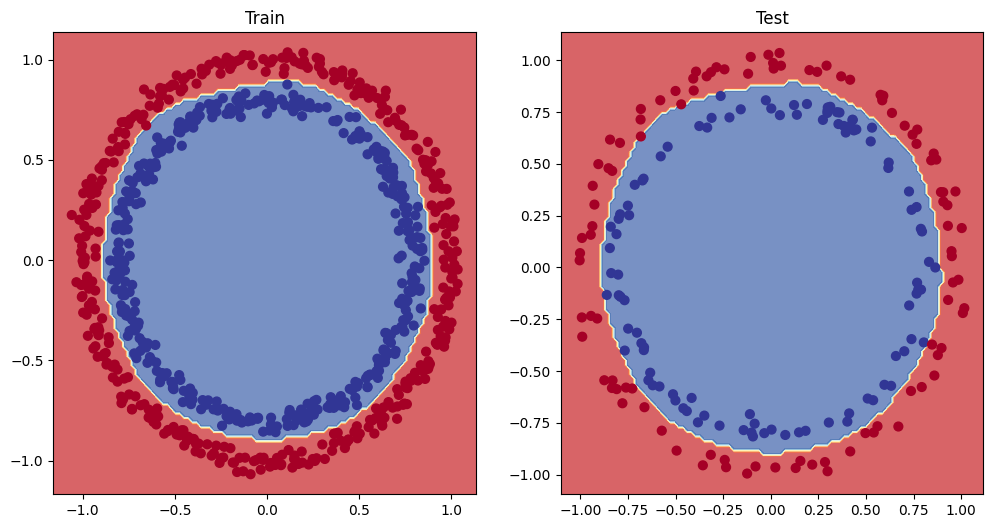

In [34]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(modelv2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(modelv2, X_test, y_test)